In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Mounting Unzipping


In [ ]:
from pathlib import Path

# Define the directory path
folder = Path("/content/drive/MyDrive/processed_3")

# Use rglob to find all .png files recursively and count them
png_count = len(list(folder.rglob("*.png"))) + len(list(folder.rglob("*.jpg")))

print(f"Number of PNG files: {png_count}")

KeyboardInterrupt: 

In [ ]:
!unzip -qq "/content/drive/MyDrive/raw_Dataset_2.zip" -d "/content/drive/MyDrive/raw_dataset_3" -x "__MACOSX/*"

## Preprocessing


In [ ]:
import os
import sys
import csv
import cv2
import time
import torch
import random
import shutil
import argparse
import numpy as np
from tqdm import tqdm
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from sklearn.model_selection import train_test_split

def is_uppercase(stem):
    """
    Returns True if the filename stem starts with an uppercase letter,
    which we use to mean it's a cat image.
    """
    if not stem:
        return False
    return stem[0].isupper()

def colorize_label(label_img, include_boundary=False):
    """
    Converts a numeric mask (PIL Image in 'L') into an RGB image.
    For include_boundary==False, the expected classes are:
      0: background -> black
      1: cat       -> orange
      2: dog       -> cyan
    For include_boundary==True, we expect an additional class:
      3: boundary  -> white
    """
    arr = np.array(label_img)
    color_arr = np.zeros((arr.shape[0], arr.shape[1], 3), dtype=np.uint8)
    if include_boundary:
        color_map = {
            0: (0,   0,   0),      # background = black
            1: (255, 165, 0),      # cat = orange
            2: (0,   255, 255),    # dog = cyan
            3: (255, 255, 255)     # boundary = white
        }
    else:
        color_map = {
            0: (0, 0, 0),
            1: (255, 165, 0),
            2: (0, 255, 255)
        }
    for class_val, color in color_map.items():
        color_arr[arr == class_val] = color
    return Image.fromarray(color_arr, mode="RGB")

def convert_label_to_three_classes(label_img, is_cat):
    """
    For TrainVal:
    Convert a grayscale label (mode "L") that may contain:
      - 0 for background,
      - 255 for boundary,
      - values in (1..254) for the animal region,
    into a new label with:
      - 0 for background (and boundary merged),
      - 1 for cat (if is_cat True),
      - 2 for dog (if is_cat False).
    """
    arr = np.array(label_img, dtype=np.uint8)
    new_label = np.zeros_like(arr, dtype=np.uint8)
    if is_cat:
        new_label[(arr > 0) & (arr < 255)] = 1
    else:
        new_label[(arr > 0) & (arr < 255)] = 2
    return Image.fromarray(new_label)

def convert_label_test(label_img, is_cat):
    """
    For Test:
    Convert an RGB label image (that contains a boundary) into a numeric mask with 4 classes:
      0 = background (black)
      3 = boundary (white; pixels where R=G=B=255)
      For the remaining animal region, assign:
          1 if is_cat is True (cat),
          2 if is_cat is False (dog).
    """
    arr = np.array(label_img)
    # Create a single-channel mask
    mask = np.zeros(arr.shape[:2], dtype=np.uint8)
    # Background: where pixel is black
    background = (arr[:,:,0] == 0) & (arr[:,:,1] == 0) & (arr[:,:,2] == 0)
    mask[background] = 0
    # Boundary: where pixel is white
    boundary = (arr[:,:,0] == 255) & (arr[:,:,1] == 255) & (arr[:,:,2] == 255)
    mask[boundary] = 3
    # Animal region: everything that is not background or boundary
    animal = ~(background | boundary)
    if is_cat:
        mask[animal] = 1
    else:
        mask[animal] = 2
    return Image.fromarray(mask)

class ResizeWithPadding:
    """For color images. Uses bilinear interpolation."""
    def __init__(self, target_size=512, padding_mode='mean', force_resize=True, resize_dims=(128, 128)):
        self.target_size = target_size
        self.force_resize = force_resize
        self.resize_dims = resize_dims
        assert padding_mode in ['mean', 'reflect', 'hybrid'], "Padding mode must be 'mean', 'reflect', or 'hybrid'"
        self.padding_mode = padding_mode

    def resize_image(self, image):
        h, w = image.shape[:2]
        scale = self.resize_dims[0] / max(h, w)
        new_w, new_h = int(w * scale), int(h * scale)
        return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    def pad_image(self, image):
        h, w = image.shape[:2]
        target_h, target_w = (self.resize_dims if self.force_resize else (self.target_size, self.target_size))
        delta_w = max(0, target_w - w)
        delta_h = max(0, target_h - h)
        top = delta_h // 2
        bottom = delta_h - top
        left = delta_w // 2
        right = delta_w - left
        if self.padding_mode == 'mean':
            mean_pixel = np.mean(image, axis=(0,1), dtype=int)
            padded_image = cv2.copyMakeBorder(image, top, bottom, left, right,
                                              cv2.BORDER_CONSTANT, value=mean_pixel.tolist())
        elif self.padding_mode == 'reflect':
            padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REFLECT)
        else:
            reflected = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REFLECT)
            mean_pixel = np.mean(image, axis=(0,1), dtype=int)
            padded_image = cv2.copyMakeBorder(reflected, top, bottom, left, right,
                                              cv2.BORDER_CONSTANT, value=mean_pixel.tolist())
        return padded_image

    def __call__(self, img):
        arr = np.array(img)
        resized = self.resize_image(arr)
        padded = self.pad_image(resized)
        return Image.fromarray(padded)

class ResizeWithPaddingLabel:
    """For label images. Uses nearest-neighbor interpolation."""
    def __init__(self, target_size=512, force_resize=False, resize_dims=(256, 256)):
        self.target_size = target_size
        self.force_resize = force_resize
        self.resize_dims = resize_dims

    def resize_image(self, image):
        h, w = image.shape[:2]
        scale = self.resize_dims[0] / max(h, w)
        new_w, new_h = int(w*scale), int(h*scale)
        return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

    def pad_image(self, image):
        h, w = image.shape[:2]
        target_h, target_w = (self.resize_dims if self.force_resize else (self.target_size, self.target_size))
        delta_w = max(0, target_w - w)
        delta_h = max(0, target_h - h)
        top = delta_h // 2
        bottom = delta_h - top
        left = delta_w // 2
        right = delta_w - left
        return cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)

    def __call__(self, label_img):
        arr = np.array(label_img)
        resized = self.resize_image(arr)
        padded = self.pad_image(resized)
        return Image.fromarray(padded)

def elastic_transform_pair(image, label, alpha=34, sigma=4):
    """Apply elastic transformation to both image and label."""
    np_img = np.array(image)
    np_label = np.array(label)
    random_state = np.random.RandomState(None)
    shape = np_img.shape[:2]
    dx = (random_state.rand(*shape) * 2 - 1)
    dy = (random_state.rand(*shape) * 2 - 1)
    dx = cv2.GaussianBlur(dx, (17,17), sigma) * alpha
    dy = cv2.GaussianBlur(dy, (17,17), sigma) * alpha
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    map_x = (x+dx).astype(np.float32)
    map_y = (y+dy).astype(np.float32)
    transformed_img = cv2.remap(np_img, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    transformed_label = cv2.remap(np_label, map_x, map_y, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT)
    return Image.fromarray(transformed_img), Image.fromarray(transformed_label)

def augment_pair(image, label, size=(256,256), apply_color=True, **params):
    """
    Applies a random subset of augmentations in random order.
    """
    augmentations = []
    augmentations.append((lambda img, lbl: (F.hflip(img), F.hflip(lbl)), params.get("flip_prob",0.5)))

    def rotate_aug(img, lbl):
        angle = random.uniform(-params.get("rotation_angle",5), params.get("rotation_angle",45))
        return F.rotate(img, angle, interpolation=Image.BILINEAR), F.rotate(lbl, angle, interpolation=Image.NEAREST)
    augmentations.append((rotate_aug, params.get("rotation_prob",0.25)))

    def translate_aug(img, lbl):
        max_translate = params.get("translate_factor", 0.05)*size[0]
        tx = int(random.uniform(-max_translate, max_translate))
        ty = int(random.uniform(-max_translate, max_translate))
        return (F.affine(img, angle=0, translate=(tx,ty), scale=1.0, shear=0, interpolation=Image.BILINEAR),
                F.affine(lbl, angle=0, translate=(tx,ty), scale=1.0, shear=0, interpolation=Image.NEAREST))
    augmentations.append((translate_aug, params.get("translate_prob",0.05)))

    def crop_aug(img, lbl):
        i,j,h,w = transforms.RandomResizedCrop.get_params(
            img, scale=params.get("crop_scale_range",(0.9,1.0)), ratio=params.get("crop_ratio_range",(1.0,1.0))
        )
        return (F.resized_crop(img, i,j,h,w,size, interpolation=Image.BILINEAR),
                F.resized_crop(lbl, i,j,h,w,size, interpolation=Image.NEAREST))
    augmentations.append((crop_aug, params.get("crop_prob",0.01)))

    def elastic_aug(img, lbl):
        return elastic_transform_pair(img, lbl, alpha=params.get("elastic_alpha",15), sigma=params.get("elastic_sigma",2))
    augmentations.append((elastic_aug, params.get("elastic_prob",0.01)))

    def scaling_aug(img, lbl):
        scale_factor = random.uniform(*params.get("scaling_range",(0.0,0.0)))
        new_size = (int(size[0]*scale_factor), int(size[1]*scale_factor))
        return (F.resize(img, new_size, interpolation=Image.BILINEAR),
                F.resize(lbl, new_size, interpolation=Image.NEAREST))
    augmentations.append((scaling_aug, params.get("scaling_prob",0.0)))

    def color_aug(img, lbl):
        if random.random() < params.get("blur_prob",0.0):
            img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(*params.get("blur_radius_range",(0.5,1.5)))))
        color_jitter = transforms.ColorJitter(**params.get("color_jitter_params",{'brightness':0.2,'contrast':0.2,'saturation':0.2,'hue':0.1}))
        img = color_jitter(img)
        return img, lbl
    augmentations.append((color_aug, params.get("color_prob",0.25)))

    random.shuffle(augmentations)
    for func, prob in augmentations:
        if random.random() < prob:
            image, label = func(image, label)
    image = F.center_crop(image, size)
    label = F.center_crop(label, size)
    return image, label

class Preprocessor:
    def __init__(self, raw_color_path, raw_label_path,
                 proc_color_path, proc_label_path,
                 resize_dim=128, do_augmentation=True,
                 is_train=True, max_images=None, aug_count=10, aug_params=None):
        self.aug_params = aug_params if aug_params is not None else {}
        self.raw_color_path = Path(raw_color_path)
        self.raw_label_path = Path(raw_label_path)
        self.proc_color_path = Path(proc_color_path)
        self.proc_label_path = Path(proc_label_path)
        self.resize_dim = resize_dim
        self.do_augmentation = do_augmentation and is_train
        self.is_train = is_train  # True for TrainVal, False for Test
        self.max_images = max_images
        self.aug_count = aug_count
        self.proc_color_path.mkdir(parents=True, exist_ok=True)
        self.proc_label_path.mkdir(parents=True, exist_ok=True)
        self.transform_img = ResizeWithPadding(target_size=224, padding_mode='mean',
                                               force_resize=True, resize_dims=(resize_dim, resize_dim))
        self.transform_label = ResizeWithPaddingLabel(target_size=224, force_resize=True,
                                                      resize_dims=(resize_dim, resize_dim))

    def process(self):
        image_extensions = (".jpg", ".jpeg", ".png")
        image_files = [f for f in self.raw_color_path.rglob("*") if f.suffix.lower() in image_extensions]
        if self.max_images is not None:
            image_files = image_files[:self.max_images]
        if not image_files:
            print("❌ No images found in", self.raw_color_path)
            return
        for img_file in image_files:
            label_file = self.raw_label_path / f"{img_file.stem}.png"
            if not label_file.exists():
                print(f"⚠️  Label for {img_file.name} not found, skipping.")
                continue

            # For TrainVal, load label in grayscale; for Test, load in RGB (to preserve boundaries)
            if self.is_train:
                label = Image.open(label_file).convert("L")
            else:
                label = Image.open(label_file).convert("RGB")
            img = Image.open(img_file).convert("RGB")
            proc_img = self.transform_img(img)
            proc_label = self.transform_label(label)
            cat_or_dog = is_uppercase(img_file.stem)  # True => cat, False => dog

            if self.is_train:
                # Merge boundary with background and set animal region accordingly.
                numeric_label = convert_label_to_three_classes(proc_label, cat_or_dog)
                colorized_label = colorize_label(numeric_label)
            else:
                # Test: Convert RGB label to numeric with boundary preserved (0,1,2,3)
                numeric_label = convert_label_test(proc_label, cat_or_dog)
                colorized_label = colorize_label(numeric_label, include_boundary=True)

            # Save processed base image/label
            if cat_or_dog:
                proc_img.save(self.proc_color_path / f"cat_{img_file.name}")
                colorized_label.save(self.proc_label_path / f"cat_{label_file.name}")
                print(f"Processed (cat) {img_file.name}")
            else:
                proc_img.save(self.proc_color_path / f"dog_{img_file.name}")
                colorized_label.save(self.proc_label_path / f"dog_{label_file.name}")
                print(f"Processed (dog) {img_file.name}")

            # Augment
            if self.is_train and self.do_augmentation:
                for i in range(self.aug_count):
                    aug_img, aug_label = augment_pair(proc_img, numeric_label,
                                                      size=(self.resize_dim, self.resize_dim),
                                                      **self.aug_params)
                    colorized_aug_label = colorize_label(aug_label)
                    if cat_or_dog:
                        aug_img.save(self.proc_color_path / f"cat_{img_file.stem}_aug_{i}{img_file.suffix}")
                        colorized_aug_label.save(self.proc_label_path / f"cat_{label_file.stem}_aug_{i}{label_file.suffix}")
                    else:
                        aug_img.save(self.proc_color_path / f"dog_{img_file.stem}_aug_{i}{img_file.suffix}")
                        colorized_aug_label.save(self.proc_label_path / f"dog_{label_file.stem}_aug_{i}{label_file.suffix}")
                    print(f"Augmented {img_file.name} -> aug {i}")

# --------------------------
# Command Line Interface
# --------------------------

if __name__ == "__main__":
    parser = argparse.ArgumentParser(
        description="Preprocess train/test images with labels/masks using relative paths."
    )
    parser.add_argument("--raw_color", type=str, required=True, default='raw/TrainVal/color')
    parser.add_argument("--raw_label", type=str, required=True, default='raw/TrainVal/label')
    parser.add_argument("--proc_color", type=str, required=True, default='Dataset/processed/TrainVal/color')
    parser.add_argument("--proc_label", type=str, required=True, default='Dataset/processed/TrainVal/label')
    parser.add_argument("--resize_dim", type=int, default=128)
    parser.add_argument("--no_augment", action="store_true")
    parser.add_argument("--max_images", type=int, default=None)
    parser.add_argument("--aug_count", type=int, default=10)
    parser.add_argument("--set_type", type=str, choices=["TrainVal", "Test"], default="TrainVal")
    parser.add_argument("--flip_prob", type=float, default=0.5)
    parser.add_argument("--rotation_angle", type=float, default=5)
    parser.add_argument("--translate_factor", type=float, default=0.05)
    parser.add_argument("--crop_scale_min", type=float, default=0.9)
    parser.add_argument("--crop_scale_max", type=float, default=1.0)
    parser.add_argument("--crop_ratio_min", type=float, default=1.0)
    parser.add_argument("--crop_ratio_max", type=float, default=1.0)
    parser.add_argument("--elastic_alpha", type=float, default=15)
    parser.add_argument("--elastic_sigma", type=float, default=2)
    parser.add_argument("--scaling_min", type=float, default=0.0)
    parser.add_argument("--scaling_max", type=float, default=0.0)
    parser.add_argument("--blur_prob", type=float, default=0.3)
    parser.add_argument("--blur_radius_min", type=float, default=0.5)
    parser.add_argument("--blur_radius_max", type=float, default=1.5)
    parser.add_argument("--color_jitter_brightness", type=float, default=0.2)
    parser.add_argument("--color_jitter_contrast", type=float, default=0.2)
    parser.add_argument("--color_jitter_saturation", type=float, default=0.2)
    parser.add_argument("--color_jitter_hue", type=float, default=0.1)

    # Example invocation inside code
    '''sys.argv = [
        'preprocessing.py',
        '--raw_color', '/content/drive/MyDrive/raw_Dataset_2/Test/color',
        '--raw_label', '/content/drive/MyDrive/raw_Dataset_2/Test/label',
        '--proc_color', '/content/drive/MyDrive/processed_3/Test/color',
        '--proc_label', '/content/drive/MyDrive/processed_3/Test/label',
        '--resize_dim', '128',
        '--no_augment',
        '--set_type', 'Test'
    ]'''
    sys.argv = ['preprocessing.py',
                '--raw_color', '/content/drive/MyDrive/raw_Dataset_2/TrainVal/color',
                '--raw_label', '/content/drive/MyDrive/raw_Dataset_2/TrainVal/label',
                '--proc_color', '/content/drive/MyDrive/processed_3/TrainVal/color',
                '--proc_label', '/content/drive/MyDrive/processed_3/TrainVal/label',
                '--resize_dim', '128',
                '--aug_count', '10',
                '--set_type', 'TrainVal',
                '--translate_factor', '0.02',
                '--elastic_alpha', '0.0',
                '--elastic_sigma', '0.05',
                '--blur_radius_min', '0.0',
                '--blur_radius_max', '0.05']

    args = parser.parse_args()

    if args.set_type == "TrainVal":
        raw_color = Path("/content/drive/MyDrive/raw_Dataset_2/TrainVal/color")
        raw_label = Path("/content/drive/MyDrive/raw_Dataset_2/TrainVal/label")
        proc_color = Path("/content/drive/MyDrive/processed_3/TrainVal/color")
        proc_label = Path("/content/drive/MyDrive/processe_3/TrainVal/label")
        is_train = True
    else:
        raw_color = Path("/content/drive/MyDrive/raw_Dataset_2/Test/color")
        raw_label = Path("/content/drive/MyDrive/raw_Dataset_2/Test/label")
        proc_color = Path("/content/drive/MyDrive/processed_3/Test/color")
        proc_label = Path("/content/drive/MyDrive/processed_3/Test/label")
        is_train = False


    aug_params = {
        "flip_prob": args.flip_prob,
        "rotation_angle": args.rotation_angle,
        "rotation_prob": 0.25,
        "translate_factor": args.translate_factor,
        "translate_prob": 0.05,
        "crop_scale_range": (args.crop_scale_min, args.crop_scale_max),
        "crop_ratio_range": (args.crop_ratio_min, args.crop_ratio_max),
        "crop_prob": 0.01,
        "elastic_alpha": args.elastic_alpha,
        "elastic_sigma": args.elastic_sigma,
        "elastic_prob": 0.01,
        "scaling_range": (0.8, 1.2),
        "scaling_prob": 0.05,
        "blur_prob": args.blur_prob,
        "blur_radius_range": (args.blur_radius_min, args.blur_radius_max),
        "color_jitter_params": {
            "brightness": args.color_jitter_brightness,
            "contrast": args.color_jitter_contrast,
            "saturation": args.color_jitter_saturation,
            "hue": args.color_jitter_hue,
        },
        "color_prob": 1.0
    }

    preprocessor = Preprocessor(
        raw_color, raw_label,
        proc_color, proc_label,
        resize_dim=args.resize_dim,
        do_augmentation=not args.no_augment,
        is_train=is_train,
        max_images=args.max_images,
        aug_count=args.aug_count,
        aug_params=aug_params
    )

    preprocessor.process()

Streaming output truncated to the last 5000 lines.
Augmented shiba_inu_111.jpg -> aug 4
Augmented shiba_inu_111.jpg -> aug 5
Augmented shiba_inu_111.jpg -> aug 6
Augmented shiba_inu_111.jpg -> aug 7
Augmented shiba_inu_111.jpg -> aug 8
Augmented shiba_inu_111.jpg -> aug 9
Processed (cat) Egyptian_Mau_154.jpg
Augmented Egyptian_Mau_154.jpg -> aug 0
Augmented Egyptian_Mau_154.jpg -> aug 1
Augmented Egyptian_Mau_154.jpg -> aug 2
Augmented Egyptian_Mau_154.jpg -> aug 3
Augmented Egyptian_Mau_154.jpg -> aug 4
Augmented Egyptian_Mau_154.jpg -> aug 5
Augmented Egyptian_Mau_154.jpg -> aug 6
Augmented Egyptian_Mau_154.jpg -> aug 7
Augmented Egyptian_Mau_154.jpg -> aug 8
Augmented Egyptian_Mau_154.jpg -> aug 9
Processed (dog) english_setter_180.jpg
Augmented english_setter_180.jpg -> aug 0
Augmented english_setter_180.jpg -> aug 1
Augmented english_setter_180.jpg -> aug 2
Augmented english_setter_180.jpg -> aug 3
Augmented english_setter_180.jpg -> aug 4
Augmented english_setter_180.jpg -> aug 5

## Imports and DataLoading

In [2]:
import os
import sys
import csv
import cv2
import time
import random
import shutil
from pathlib import Path
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from PIL import Image, ImageFilter
from sklearn.model_selection import train_test_split

In [15]:
# Define the source path on Google Drive and the local target path
drive_dataset_path = Path("/content/drive/MyDrive/processed_3")
local_dataset_path = Path("/content/local_dataset")

# Copy the dataset only if it hasn't been copied yet
if not local_dataset_path.exists():
    print("Copying dataset from Google Drive to local storage...")
    shutil.copytree(drive_dataset_path, local_dataset_path)
    print("Dataset copied to local storage.")
else:
    print("Local dataset already exists.")

Local dataset already exists.


In [11]:
# # Define the source path on Google Drive and the local target path
# local_dataset_path = Path("/content/processed_3")

# # Copy the dataset only if it hasn't been copied yet
# if not local_dataset_path.exists():
#     print("Copying dataset from Google Drive to local storage...")
#     print("Dataset copied to local storage.")
# else:
#     print("Local dataset already exists.")

Copying dataset from Google Drive to local storage...
Dataset copied to local storage.


In [14]:
from pathlib import Path
import shutil

# Define the destination folder.
dest_folder = Path("/content/processed_3")

# Remove any existing local folder to avoid conflicts.
if dest_folder.exists():
    shutil.rmtree(dest_folder)
    print("Removed existing /content/processed_3 folder.")

# Use the shell command to unzip the file from Google Drive to /content.
!unzip /content/drive/MyDrive/Sams_processed_data.zip -d /content

# Check if the destination folder exists.
if dest_folder.exists():
    print("Extraction successful: 'Sams_processed_data' folder is now available in the local runtime.")
else:
    print("Extraction completed. Please verify the file structure.")

Streaming output truncated to the last 5000 lines.
  inflating: /content/processed_3/Test/label/cat_Sphynx_46.png  
  inflating: /content/processed_3/Test/label/dog_basset_hound_35.png  
  inflating: /content/processed_3/Test/label/dog_great_pyrenees_95.png  
  inflating: /content/processed_3/Test/label/dog_american_bulldog_39.png  
  inflating: /content/processed_3/Test/label/cat_Bombay_23.png  
  inflating: /content/processed_3/Test/label/dog_english_setter_51.png  
  inflating: /content/processed_3/Test/label/dog_english_setter_92.png  
  inflating: /content/processed_3/Test/label/cat_Ragdoll_262.png  
  inflating: /content/processed_3/Test/label/dog_scottish_terrier_46.png  
  inflating: /content/processed_3/Test/label/dog_great_pyrenees_94.png  
  inflating: /content/processed_3/Test/label/dog_great_pyrenees_57.png  
  inflating: /content/processed_3/Test/label/cat_Ragdoll_90.png  
  inflating: /content/processed_3/Test/label/cat_Ragdoll_84.png  
  inflating: /content/processed_3/

In [5]:
class SegmentationDataset(Dataset):
    """
    A simple dataset for image segmentation.

    Assumes:
      - root_dir/color: contains the color (RGB) images.
      - root_dir/label: contains the corresponding label images (in color).
      - Each label image has the same stem as its corresponding color image,
        and uses a .png extension.

    Optional transforms:
      - transform_img: transformation to apply to color images (e.g. normalization).
      - transform_label: transformation to apply to label images (less common).

    Returns a tuple (image, label) where:
      - image is a Tensor of shape (C, H, W).
      - label is a Tensor of shape (H, W) containing integer class indices:
         0 = background
         1 = cat
         2 = dog
    """
    def __init__(self, root_dir, transform_img=None, transform_label=None):
        self.root_dir = Path(root_dir)
        self.color_dir = self.root_dir / "color"
        self.label_dir = self.root_dir / "label"
        self.transform_img = transform_img
        self.transform_label = transform_label

        # Gather all image files from the color directory and filter out those missing corresponding label files.
        all_files = sorted([
            f for f in self.color_dir.iterdir()
            if f.is_file() and f.suffix.lower() in [".png", ".jpg", ".jpeg"]
        ])
        self.image_files = []
        for f in all_files:
            label_path = self.label_dir / (f.stem + ".png")
            if label_path.exists():
                self.image_files.append(f)
            else:
                print(f"Warning: Missing label for {f.name}; skipping.")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # 1) Load color image in RGB
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")

        # 2) Build corresponding label path, open in RGB as well
        label_path = self.label_dir / (img_path.stem + ".png")
        label_img = Image.open(label_path).convert("RGB")  # color-coded label

        # 3) Optional transform on the color image
        if self.transform_img:
            image = self.transform_img(image)
        else:
            image = transforms.ToTensor()(image)

        # 4) Convert the color-coded label to a NumPy array
        label_np = np.array(label_img, dtype=np.uint8)  # shape = (H, W, 3)

        # Create an empty single-channel array to store class indices
        #   0 = background (black)
        #   1 = cat (orange = [255,165,0])
        #   2 = dog (cyan = [0,255,255])
        label_new = np.zeros((label_np.shape[0], label_np.shape[1]), dtype=np.int64)

        # Identify background = black
        background_mask = (
            (label_np[..., 0] == 0) &
            (label_np[..., 1] == 0) &
            (label_np[..., 2] == 0)
        )
        label_new[background_mask] = 0

        # Identify cat = orange
        cat_mask = (
            (label_np[..., 0] == 255) &
            (label_np[..., 1] == 165) &
            (label_np[..., 2] == 0)
        )
        label_new[cat_mask] = 1

        # Identify dog = cyan
        dog_mask = (
            (label_np[..., 0] == 0) &
            (label_np[..., 1] == 255) &
            (label_np[..., 2] == 255)
        )
        label_new[dog_mask] = 2

        # Convert to torch tensor
        label_tensor = torch.from_numpy(label_new).long()

        # 5) Optional transform on the label (usually None)
        if self.transform_label:
            label_tensor = self.transform_label(label_tensor)

        return image, label_tensor

In [ ]:
# class PatchBasedDataset(Dataset):
#     def __init__(self, root_dir, patch_size=128, transform_img=None, transform_label=None):
#         """
#         root_dir: Path to e.g. /content/processed/TrainVal
#         patch_size: size of the patch to randomly crop
#         transform_img: transformations to apply to the color image
#         transform_label: transformations to apply to the label (optional)
#         """
#         self.base_dataset = SegmentationDataset(root_dir, transform_img, transform_label)
#         self.patch_size = patch_size

#     def __len__(self):
#         return len(self.base_dataset)

#     def __getitem__(self, idx):
#         # Retrieve the full image and mask
#         image, mask = self.base_dataset[idx]  # image: (C, H, W), mask: (H, W)

#         # Convert to PIL for random crop
#         to_pil_img = transforms.ToPILImage()
#         pil_image = to_pil_img(image)
#         pil_mask = Image.fromarray(mask.cpu().numpy().astype(np.uint8), mode="L")

#         # Random crop
#         i, j, h, w = transforms.RandomCrop.get_params(
#             pil_image, output_size=(self.patch_size, self.patch_size)
#         )
#         pil_image_patch = transforms.functional.crop(pil_image, i, j, h, w)
#         pil_mask_patch = transforms.functional.crop(pil_mask, i, j, h, w)

#         # Convert the cropped image back to a tensor
#         image_patch = transforms.ToTensor()(pil_image_patch)

#         mask_patch_np = np.array(pil_mask_patch, dtype=np.int64)
#         mask_patch = torch.from_numpy(mask_patch_np).long()

#         return image_patch, mask_patch

## Imports and Utils

In [6]:


# -------------- IoU for segmentation ---------------
def compute_iou(preds, targets, num_classes=3):
    """
    Computes the Intersection-over-Union (IoU) for each class.

    Args:
      preds: Tensor of predicted class indices (N, H, W)
      targets: Tensor of ground truth class indices (N, H, W)
      num_classes: Number of classes

    Returns:
      A list with IoU for each class.
    """
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (targets == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))  # or 0.0
        else:
            ious.append(intersection / union)
    return ious

# -------------- Visualization ---------------
def visualize_reconstruction(model, dataset, device, num_samples=3):
    """
    Visualize a few reconstructed images from the autoencoder.
    """
    model.eval()
    loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
    images, _ = next(iter(loader))  # we don't care about labels for autoencoder
    images = images.to(device)
    with torch.no_grad():
        recons = model(images)
    # Move to CPU
    images = images.cpu()
    recons = recons.cpu()

    fig, axes = plt.subplots(2, num_samples, figsize=(3*num_samples, 6))
    for i in range(num_samples):
        # Original
        axes[0, i].imshow(images[i].permute(1,2,0).numpy())
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")
        # Reconstructed
        axes[1, i].imshow(recons[i].permute(1,2,0).numpy())
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis("off")
    plt.tight_layout()
    plt.show()

def visualize_segmentation_predictions(model, dataset, device, num_samples=3, num_classes=3):
    """
    Visualize a few segmentation predictions from a trained model
    (frozen encoder + new decoder).
    """
    model.eval()
    loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
    images, masks = next(iter(loader))
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)  # raw logits
        preds = torch.argmax(outputs, dim=1)  # (N, H, W)
    # Move to CPU
    images = images.cpu()
    masks = masks.cpu()
    preds = preds.cpu()

    fig, axes = plt.subplots(3, num_samples, figsize=(3*num_samples, 9))
    for i in range(num_samples):
        # Input image
        axes[0, i].imshow(images[i].permute(1,2,0).numpy())
        axes[0, i].set_title("Input")
        axes[0, i].axis("off")
        # Ground truth mask
        axes[1, i].imshow(masks[i], cmap='gray', vmin=0, vmax=num_classes-1)
        axes[1, i].set_title("Ground Truth Mask")
        axes[1, i].axis("off")
        # Prediction
        axes[2, i].imshow(preds[i], cmap='gray', vmin=0, vmax=num_classes-1)
        axes[2, i].set_title("Prediction")
        axes[2, i].axis("off")
    plt.tight_layout()
    plt.show()

## Models And Training

Pretraining Reconstruction

In [ ]:

# # Enable cudnn benchmark for possible speedups
# cudnn.benchmark = True

# class SimpleAutoencoder(nn.Module):
#     def __init__(self, in_channels=3, latent_dim=512):
#         super().__init__()
#         self.enc = nn.Sequential(
#             nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(True),
#             nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(True),
#             nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(True),
#             nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(True),
#         )
#         self.fc_enc = nn.Linear(256*8*8, latent_dim)

#         self.fc_dec = nn.Linear(latent_dim, 256*8*8)
#         self.dec = nn.Sequential(
#             nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(32, in_channels, kernel_size=4, stride=2, padding=1),
#             nn.Sigmoid()
#         )

#     def encode(self, x):
#         x = self.enc(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc_enc(x)
#         return x

#     def decode(self, z):
#         z = self.fc_dec(z)
#         z = z.view(z.size(0), 256, 8, 8)
#         out = self.dec(z)
#         return out

#     def forward(self, x):
#         z = self.encode(x)
#         out = self.decode(z)
#         return out

# def train_autoencoder(
#     model,
#     train_dataset,
#     val_dataset=None,
#     epochs=50,
#     batch_size=64,             # <--- Use a LARGER batch for heavier GPU load
#     lr=5e-4,
#     save_every=5,
#     early_stopping_patience=None,
#     device="cuda"
# ):
#     """
#     Train the autoencoder on (image -> image) reconstruction.
#     """
#     print(f"Using device inside train_autoencoder: {device}")
#     model = model.to(device)  # ensure model is on GPU

#     train_loader = DataLoader(
#         train_dataset,
#         batch_size=batch_size,
#         shuffle=True,
#         pin_memory=True       # <--- pin_memory speeds up host to GPU transfer
#     )
#     if val_dataset is not None:
#         val_loader = DataLoader(
#             val_dataset,
#             batch_size=batch_size,
#             shuffle=False,
#             pin_memory=True
#         )
#     else:
#         val_loader = None

#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     criterion = nn.MSELoss()

#     best_val_loss = float("inf")
#     epochs_no_improve = 0

#     for epoch in range(1, epochs+1):
#         start_time = time.time()
#         model.train()
#         running_loss = 0.0

#         for imgs, _ in train_loader:
#             # Move batch to GPU
#             imgs = imgs.to(device, non_blocking=True)

#             optimizer.zero_grad()
#             recons = model(imgs)
#             loss = criterion(recons, imgs)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item() * imgs.size(0)

#             # Debug: print allocated GPU memory (MB)
#             # comment out if it prints too often
#             # print("GPU mem allocated (MB):", torch.cuda.memory_allocated() / 2**20)

#         train_epoch_loss = running_loss / len(train_loader.dataset)

#         # Validation
#         if val_loader is not None:
#             model.eval()
#             val_loss = 0.0
#             with torch.no_grad():
#                 for imgs, _ in val_loader:
#                     imgs = imgs.to(device, non_blocking=True)
#                     recons = model(imgs)
#                     loss = criterion(recons, imgs)
#                     val_loss += loss.item() * imgs.size(0)
#             val_epoch_loss = val_loss / len(val_loader.dataset)
#             print(f"Epoch [{epoch}/{epochs}] - "
#                   f"Train Loss: {train_epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}")
#         else:
#             val_epoch_loss = train_epoch_loss
#             print(f"Epoch [{epoch}/{epochs}] - Train Loss: {train_epoch_loss:.4f}")

#         # Save every 'save_every' epochs
#         if epoch % save_every == 0:
#             encoder_path = f"encoder_epoch_{epoch}.pth"
#             decoder_path = f"decoder_epoch_{epoch}.pth"
#             torch.save(model.enc.state_dict(), encoder_path)
#             torch.save(model.dec.state_dict(), decoder_path)
#             print(f"Saved encoder & decoder checkpoints at epoch {epoch}")

#         # Early stopping
#         if val_loader is not None and early_stopping_patience is not None:
#             if val_epoch_loss < best_val_loss:
#                 best_val_loss = val_epoch_loss
#                 epochs_no_improve = 0
#             else:
#                 epochs_no_improve += 1
#                 if epochs_no_improve >= early_stopping_patience:
#                     print(f"Early stopping triggered at epoch {epoch}")
#                     break

#         epoch_time = time.time() - start_time
#         print(f"Epoch {epoch} took {epoch_time:.2f} sec")

#     # Final save of the entire autoencoder
#     torch.save(model.state_dict(), "autoencoder_final.pth")
#     print("Training completed. Final model saved as autoencoder_final.pth")

#     return model

In [7]:
# Enable cudnn benchmark for possible speedups
cudnn.benchmark = True

class DecoderModule(nn.Module):
    def __init__(self, fc_dec, dec4, dec3_conv, dec3, dec2_conv, dec2, dec1_conv, dec1):
        super().__init__()
        self.fc_dec = fc_dec
        self.dec4 = dec4
        self.dec3_conv = dec3_conv
        self.dec3 = dec3
        self.dec2_conv = dec2_conv
        self.dec2 = dec2
        self.dec1_conv = dec1_conv
        self.dec1 = dec1

    def forward(self, latent, e1, e2, e3):
        d4 = self.fc_dec(latent)
        d4 = d4.view(-1, 256, 8, 8)
        d4 = self.dec4(d4)
        d4_cat = torch.cat([d4, e3], dim=1)
        d3 = self.dec3_conv(d4_cat)
        d3 = self.dec3(d3)
        d3_cat = torch.cat([d3, e2], dim=1)
        d2 = self.dec2_conv(d3_cat)
        d2 = self.dec2(d2)
        d2_cat = torch.cat([d2, e1], dim=1)
        d1 = self.dec1_conv(d2_cat)
        out = self.dec1(d1)
        return out

class SimpleAutoencoder(nn.Module):
    def __init__(self, in_channels=3, latent_dim=512, dropout_rate=0.1):
        super().__init__()
        # ---------------- Encoder ----------------
        # Block 1: Output (B, 32, 64, 64)
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate)
        )
        # Block 2: Output (B, 64, 32, 32)
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate)
        )
        # Block 3: Output (B, 128, 16, 16)
        self.enc3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate)
        )
        # Block 4: Output (B, 256, 8, 8)
        self.enc4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate)
        )

        # Bottleneck: Fully connected layers
        self.fc_enc = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, 256 * 8 * 8)

        # ---------------- Decoder ----------------
        # Decode from bottleneck to (B, 256, 8, 8) then upsample to (B, 128, 16, 16)
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        # After concatenating with e3 (128 channels) → (B, 256, 16, 16)
        self.dec3_conv = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        # After concatenating with e2 (64 channels) → (B, 128, 32, 32)
        self.dec2_conv = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        # After concatenating with e1 (32 channels) → (B, 64, 64, 64)
        self.dec1_conv = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        # Final upsample to recover original dimensions: Output (B, in_channels, 128, 128)
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(32, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Ensures outputs are in [0,1]
        )
        # ---------------- Add attributes for separate saving ----------------
        self.enc = nn.Sequential(self.enc1, self.enc2, self.enc3, self.enc4)
        self.dec = DecoderModule(self.fc_dec, self.dec4, self.dec3_conv, self.dec3,
                                  self.dec2_conv, self.dec2, self.dec1_conv, self.dec1)

    def encode(self, x):
        e1 = self.enc1(x)        # (B, 32, 64, 64)
        e2 = self.enc2(e1)       # (B, 64, 32, 32)
        e3 = self.enc3(e2)       # (B, 128, 16, 16)
        e4 = self.enc4(e3)       # (B, 256, 8, 8)
        flat = e4.view(e4.size(0), -1)
        latent = self.fc_enc(flat)
        return e1, e2, e3, e4, latent

    def decode(self, latent, e1, e2, e3):
        # Reconstruct bottleneck feature map
        d4 = self.fc_dec(latent)
        d4 = d4.view(-1, 256, 8, 8)
        d4 = self.dec4(d4)               # (B, 128, 16, 16)
        # Skip connection: concatenate with encoder block 3 output
        d4_cat = torch.cat([d4, e3], dim=1)  # (B, 256, 16, 16)
        d3 = self.dec3_conv(d4_cat)          # (B, 128, 16, 16)
        d3 = self.dec3(d3)                   # (B, 64, 32, 32)
        # Skip connection: concatenate with encoder block 2 output
        d3_cat = torch.cat([d3, e2], dim=1)   # (B, 128, 32, 32)
        d2 = self.dec2_conv(d3_cat)           # (B, 64, 32, 32)
        d2 = self.dec2(d2)                    # (B, 32, 64, 64)
        # Skip connection: concatenate with encoder block 1 output
        d2_cat = torch.cat([d2, e1], dim=1)    # (B, 64, 64, 64)
        d1 = self.dec1_conv(d2_cat)           # (B, 32, 64, 64)
        out = self.dec1(d1)                   # (B, in_channels, 128, 128)
        return out

    def forward(self, x):
        e1, e2, e3, e4, latent = self.encode(x)
        out = self.decode(latent, e1, e2, e3)
        return out

def train_autoencoder(
    model,
    train_dataset,
    val_dataset=None,
    epochs=50,
    batch_size=64,             # Using a larger batch size to better utilize the T4 GPU
    lr=5e-4,
    save_every=5,
    early_stopping_patience=None,
    device="cuda"
):
    """
    Train the autoencoder on (image -> image) reconstruction.
    Optimized with mixed precision training.
    """
    print(f"Using device inside train_autoencoder: {device}")
    model = model.to(device)

    save_dir = os.path.join("/content/drive/MyDrive","checkpoints", "autoencoder")
    os.makedirs(save_dir, exist_ok=True)

    # Initialize GradScaler for mixed precision training
    scaler = torch.amp.GradScaler()

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True       # Speeds up host-to-device transfer
    )
    if val_dataset is not None:
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            pin_memory=True
        )
    else:
        val_loader = None

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_val_loss = float("inf")
    epochs_no_improve = 0

    for epoch in range(1, epochs+1):
        start_time = time.time()
        model.train()
        running_loss = 0.0

        for imgs, _ in train_loader:
            imgs = imgs.to(device, non_blocking=True)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                recons = model(imgs)
                loss = criterion(recons, imgs)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * imgs.size(0)

        train_epoch_loss = running_loss / len(train_loader.dataset)

        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for imgs, _ in val_loader:
                    imgs = imgs.to(device, non_blocking=True)
                    with torch.cuda.amp.autocast():
                        recons = model(imgs)
                        loss = criterion(recons, imgs)
                    val_loss += loss.item() * imgs.size(0)
            val_epoch_loss = val_loss / len(val_loader.dataset)
            print(f"Epoch [{epoch}/{epochs}] - Train Loss: {train_epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}")
        else:
            val_epoch_loss = train_epoch_loss
            print(f"Epoch [{epoch}/{epochs}] - Train Loss: {train_epoch_loss:.4f}")

        if epoch % save_every == 0:
            encoder_path = os.path.join(save_dir, f"encoder_epoch_{epoch}.pth")
            decoder_path = os.path.join(save_dir, f"decoder_epoch_{epoch}.pth")
            torch.save(model.enc.state_dict(), encoder_path)
            torch.save(model.dec.state_dict(), decoder_path)
            print(f"Saved encoder & decoder checkpoints at epoch {epoch}")

        if val_loader is not None and early_stopping_patience is not None:
            if val_epoch_loss < best_val_loss:
                best_val_loss = val_epoch_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= early_stopping_patience:
                    print(f"Early stopping triggered at epoch {epoch}")
                    break

        epoch_time = time.time() - start_time
        print(f"Epoch {epoch} took {epoch_time:.2f} sec")

    final_path = os.path.join(save_dir, "autoencoder_final.pth")
    torch.save(model.state_dict(), final_path)
    print(f"Training completed. Final model saved as {final_path}")

    return model

Finetuning segmentation decoder

In [ ]:
# class SegmentationDecoder(nn.Module):
#     """
#     A simple upsampling decoder that takes the compressed feature map
#     from the autoencoder's encoder output (before flattening!)
#     and produces segmentation logits.
#     """
#     def __init__(self, input_channels=256, num_classes=3):
#         super().__init__()
#         # For a 128x128 input, the autoencoder's last conv feature map
#         # is (256, 8, 8) if following the above structure. We'll decode from that shape.

#         self.seg_dec = nn.Sequential(
#             nn.ConvTranspose2d(input_channels, 128, kernel_size=4, stride=2, padding=1), # -> (128,16,16)
#             nn.ReLU(True),
#             nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),             # -> (64,32,32)
#             nn.ReLU(True),
#             nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),              # -> (32,64,64)
#             nn.ReLU(True),
#             nn.ConvTranspose2d(32, num_classes, kernel_size=4, stride=2, padding=1)      # -> (3,128,128) for 3 classes
#         )

#     def forward(self, feature_map):
#         """
#         feature_map: shape (B, 256, 8, 8) from the frozen encoder
#         returns: (B, num_classes, 128, 128) logits
#         """
#         return self.seg_dec(feature_map)

# class Segmenter(nn.Module):
#     """
#     Wraps a frozen autoencoder encoder and a new segmentation decoder.
#     """
#     def __init__(self, autoencoder, num_classes=3):
#         super().__init__()
#         # Freeze the encoder
#         # We'll use everything up to the last conv layer in autoencoder.enc
#         self.frozen_encoder = autoencoder.enc
#         for param in self.frozen_encoder.parameters():
#             param.requires_grad = False

#         # Our new segmentation decoder
#         self.seg_decoder = SegmentationDecoder(input_channels=256, num_classes=num_classes)

#     def forward(self, x):
#         """
#         x: (B, 3, 128, 128)
#         returns: logits of shape (B, num_classes, 128, 128)
#         """
#         # pass x through the autoencoder encoder
#         with torch.no_grad():
#             feature_map = self.frozen_encoder(x)  # (B, 256, 8, 8)
#         # pass the feature map to our learnable segmentation decoder
#         logits = self.seg_decoder(feature_map)
#         return logits

# def train_segmentation_decoder(
#     model,
#     train_dataset,
#     val_dataset=None,
#     epochs=30,
#     batch_size=8,
#     lr=1e-3,
#     save_every=5,
#     early_stopping_patience=10,
#     num_classes=3,
#     device="cuda"
# ):
#     """
#     Train the segmentation decoder (with frozen encoder) using cross-entropy.
#     Evaluate IoU and/or validation loss for early stopping.

#     - model: Segmenter(...) instance
#     - train_dataset: segmentation dataset returning (img, mask)
#     - val_dataset: optional dataset for validation
#     - epochs, batch_size, lr: typical training hyperparams
#     - save_every: save model weights every N epochs
#     - early_stopping_patience: stops if val iou doesn't improve for this many epochs
#     - num_classes: e.g. 3 (background, cat, other?), used for IoU
#     - device: "cuda", "cpu", or "mps"

#     Returns: the best model (highest val IoU).
#     """
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     if val_dataset is not None:
#         val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
#     else:
#         val_loader = None

#     # Right after you define train_loader, val_loader, etc.:
#     training_stats = []

#     # Example class weights [1.0, 1.0, 2.0] if the 3rd class is underrepresented
#     class_weights = torch.tensor([1.0, 1.0, 2.0], device=device)  # <--- ADDED
#     criterion = nn.CrossEntropyLoss(weight=class_weights)

#     # Only the segmentation decoder’s parameters are trainable
#     optimizer = optim.Adam(model.seg_decoder.parameters(), lr=lr)

#     model = model.to(device)

#     best_val_iou = 0.0
#     epochs_no_improve = 0
#     best_model_state = None

#     for epoch in range(1, epochs+1):
#         start_time = time.time()

#         model.train()
#         running_loss = 0.0

#         for imgs, masks in train_loader:
#             imgs = imgs.to(device)
#             masks = masks.to(device)
#             optimizer.zero_grad()
#             logits = model(imgs)        # (B, num_classes, 128,128)
#             loss = criterion(logits, masks)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item() * imgs.size(0)

#         train_epoch_loss = running_loss / len(train_loader.dataset)

#         # Validation
#         if val_loader is not None:
#             model.eval()
#             val_loss = 0.0
#             all_preds = []
#             all_targets = []
#             with torch.no_grad():
#                 for val_imgs, val_masks in val_loader:
#                     val_imgs = val_imgs.to(device)
#                     val_masks = val_masks.to(device)
#                     val_logits = model(val_imgs)
#                     val_batch_loss = criterion(val_logits, val_masks)
#                     val_loss += val_batch_loss.item() * val_imgs.size(0)

#                     preds = torch.argmax(val_logits, dim=1)
#                     all_preds.append(preds.cpu())
#                     all_targets.append(val_masks.cpu())

#             val_loss /= len(val_loader.dataset)
#             all_preds = torch.cat(all_preds, dim=0)
#             all_targets = torch.cat(all_targets, dim=0)
#             ious = compute_iou(all_preds, all_targets, num_classes=num_classes)
#             mean_iou = np.nanmean(ious)

#             print(f"Epoch [{epoch}/{epochs}] - Train Loss: {train_epoch_loss:.4f}, "
#                   f"Val Loss: {val_loss:.4f}, Val mIoU: {mean_iou:.4f}, per-class: {ious}")
#         else:
#             # If no val_loader, just print train loss
#             val_loss = train_epoch_loss
#             mean_iou = float('nan')
#             print(f"Epoch [{epoch}/{epochs}] - Train Loss: {train_epoch_loss:.4f}")

#         end_time = time.time()          # <--- End timer
#         epoch_duration = end_time - start_time

#         # Store stats for this epoch
#         training_stats.append({
#             'epoch': epoch,
#             'train_loss': train_epoch_loss,
#             'val_loss': val_loss,
#             'val_mIoU': mean_iou,
#             'time_sec': epoch_duration
#         })

#         print(f"Epoch [{epoch}/{epochs}] took {epoch_duration:.2f}s. "
#               f"Train Loss: {train_epoch_loss:.4f}, Val Loss: {val_loss:.4f}, IoU: {mean_iou:.4f}")

#         # Save checkpoint every 'save_every' epochs
#         if epoch % save_every == 0:
#             checkpoint_path = f"segmenter_epoch_{epoch}.pth"
#             torch.save(model.state_dict(), checkpoint_path)
#             print(f"Saved segmentation model checkpoint at epoch {epoch}")

#         # Early Stopping on IoU
#         if val_loader is not None:
#             if mean_iou > best_val_iou:
#                 best_val_iou = mean_iou
#                 best_model_state = model.state_dict()
#                 epochs_no_improve = 0
#             else:
#                 epochs_no_improve += 1
#                 if epochs_no_improve >= early_stopping_patience:
#                     print(f"Early stopping triggered at epoch {epoch}")
#                     break

#     # If we had validation, load the best model state
#     if val_loader is not None and best_model_state is not None:
#         model.load_state_dict(best_model_state)
#         print(f"Loaded best model state with mIoU={best_val_iou:.4f}")

#     # Final save
#     torch.save(model.state_dict(), "segmenter_final.pth")
#     print("Segmentation training completed. Final model saved as segmenter_final.pth")

#     # At the very end of the function (before return model)
#     df = pd.DataFrame(training_stats)
#     df.to_csv("segmentation_training_log.csv", index=False)
#     print("Saved training log to segmentation_training_log.csv")

#     return model

In [8]:
# ---------------- Segmentation Decoder ----------------
class SegmentationDecoder(nn.Module):
    """
    A simple upsampling decoder that takes the compressed feature map
    from the autoencoder's encoder output (before flattening!)
    and produces segmentation logits.
    """
    def __init__(self, input_channels=256, num_classes=3, dropout_rate=0.1):
        super().__init__()
        self.seg_dec = nn.Sequential(
            nn.ConvTranspose2d(input_channels, 128, kernel_size=4, stride=2, padding=1),  # -> (128,16,16)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),               # -> (64,32,32)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),                # -> (32,64,64)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.ConvTranspose2d(32, num_classes, kernel_size=4, stride=2, padding=1)         # -> (num_classes,128,128)
        )

    def forward(self, feature_map):
        """
        feature_map: shape (B, 256, 8, 8) from the frozen encoder
        returns: (B, num_classes, 128, 128) logits
        """
        return self.seg_dec(feature_map)

# ---------------- Segmenter ----------------
class Segmenter(nn.Module):
    """
    Wraps a frozen autoencoder encoder and a new segmentation decoder.
    """
    def __init__(self, autoencoder, num_classes=3, dropout_rate=0.1):
        super().__init__()
        # Freeze the encoder
        self.frozen_encoder = autoencoder.enc
        for param in self.frozen_encoder.parameters():
            param.requires_grad = False

        # Our new segmentation decoder
        self.seg_decoder = SegmentationDecoder(input_channels=256, num_classes=num_classes, dropout_rate=dropout_rate)

    def forward(self, x):
        """
        x: (B, 3, 128, 128)
        returns: logits of shape (B, num_classes, 128, 128)
        """
        with torch.no_grad():
            feature_map = self.frozen_encoder(x)  # (B, 256, 8, 8)
        logits = self.seg_decoder(feature_map)
        return logits

# ---------------- Training Function ----------------
def train_segmentation_decoder(
    model,
    train_dataset,
    val_dataset=None,
    epochs=30,
    batch_size=64,
    lr=1e-3,
    save_every=5,
    early_stopping_patience=10,
    num_classes=3,
    device="cuda"
):
    """
    Train the segmentation decoder (with frozen encoder) using cross-entropy.
    Evaluate IoU and/or validation loss for early stopping.
    Optimized with mixed precision training.
    """
    save_dir = os.path.join("/content/drive/MyDrive", "checkpoints", "segmenter")
    os.makedirs(save_dir, exist_ok=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True) if val_dataset is not None else None

    training_stats = []
    class_weights = torch.tensor([1.0, 1.0, 2.0], device=device)  # Example class weights
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Only train the segmentation decoder parameters
    optimizer = optim.Adam(model.seg_decoder.parameters(), lr=lr)
    model = model.to(device)

    scaler = torch.amp.GradScaler()  # Initialize AMP scaler

    best_val_iou = 0.0
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(1, epochs+1):
        start_time = time.time()
        model.train()
        running_loss = 0.0

        for imgs, masks in train_loader:
            imgs = imgs.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                logits = model(imgs)  # (B, num_classes, 128,128)
                loss = criterion(logits, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item() * imgs.size(0)

        train_epoch_loss = running_loss / len(train_loader.dataset)

        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            all_preds = []
            all_targets = []
            with torch.no_grad():
                for val_imgs, val_masks in val_loader:
                    val_imgs = val_imgs.to(device, non_blocking=True)
                    val_masks = val_masks.to(device, non_blocking=True)
                    with torch.cuda.amp.autocast():
                        val_logits = model(val_imgs)
                        val_batch_loss = criterion(val_logits, val_masks)
                    val_loss += val_batch_loss.item() * val_imgs.size(0)
                    preds = torch.argmax(val_logits, dim=1)
                    all_preds.append(preds.cpu())
                    all_targets.append(val_masks.cpu())
            val_loss /= len(val_loader.dataset)
            all_preds = torch.cat(all_preds, dim=0)
            all_targets = torch.cat(all_targets, dim=0)
            ious = compute_iou(all_preds, all_targets, num_classes=num_classes)
            mean_iou = np.nanmean(ious)
            print(f"Epoch [{epoch}/{epochs}] - Train Loss: {train_epoch_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val mIoU: {mean_iou:.4f}, per-class: {ious}")
        else:
            val_loss = train_epoch_loss
            mean_iou = float('nan')
            print(f"Epoch [{epoch}/{epochs}] - Train Loss: {train_epoch_loss:.4f}")

        epoch_duration = time.time() - start_time
        training_stats.append({
            'epoch': epoch,
            'train_loss': train_epoch_loss,
            'val_loss': val_loss,
            'val_mIoU': mean_iou,
            'time_sec': epoch_duration
        })
        print(f"Epoch [{epoch}/{epochs}] took {epoch_duration:.2f}s. "
              f"Train Loss: {train_epoch_loss:.4f}, Val Loss: {val_loss:.4f}, IoU: {mean_iou:.4f}")

        if epoch % save_every == 0:
            checkpoint_path = os.path.join(save_dir, f"segmenter_epoch_{epoch}.pth")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Saved segmentation model checkpoint at epoch {epoch}")

        if val_loader is not None:
            if mean_iou > best_val_iou:
                best_val_iou = mean_iou
                best_model_state = model.state_dict()
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= early_stopping_patience:
                    print(f"Early stopping triggered at epoch {epoch}")
                    break

    if val_loader is not None and best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model state with mIoU={best_val_iou:.4f}")

    final_path = os.path.join(save_dir, "segmenter_final.pth")
    torch.save(model.state_dict(), final_path)
    print(f"Segmentation training completed. Final model saved as {final_path}")

    df = pd.DataFrame(training_stats)
    df.to_csv("segmentation_training_log.csv", index=False)
    print("Saved training log to segmentation_training_log.csv")

    return model

## Pretraining Encoder Reconstruction

## Main Script

In [ ]:
print("torch.cuda.is_available():", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device name:", torch.cuda.get_device_name(0))

torch.cuda.is_available(): True
Device count: 1
Current device name: Tesla T4


In [ ]:
!nvidia-smi

Fri Apr  4 10:25:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 90.9 MB/s eta 0:00:00


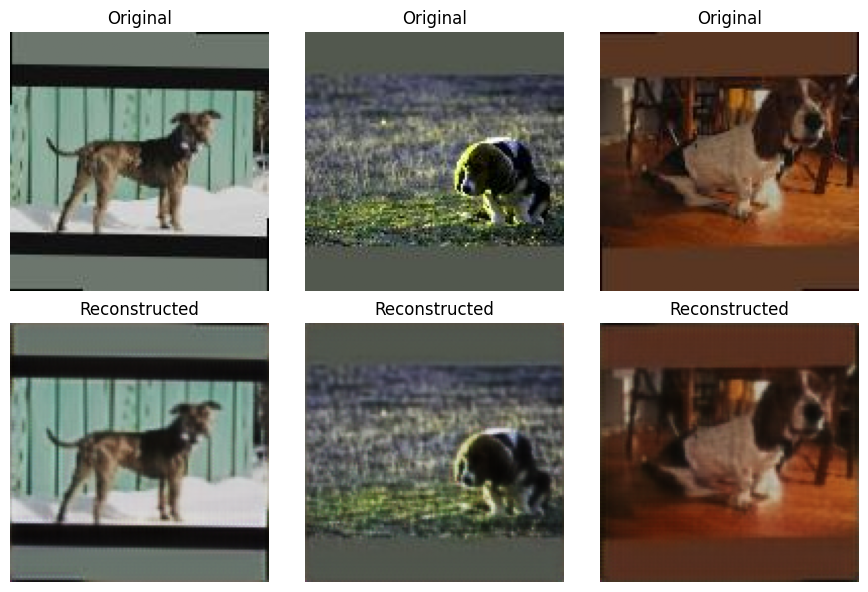

Loaded final autoencoder weights from /content/drive/MyDrive/checkpoints/autoencoder/autoencoder_final.pth
Loaded segmentation model checkpoint from /content/drive/MyDrive/checkpoints/segmenter/segmenter_final.pth


<ipython-input-7-a38adcce3336>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-7-a38adcce3336>:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/200] - Train Loss: 0.2752, Val Loss: 0.3316, Val mIoU: 0.6347, per-class: [0.8801457771483356, 0.4460548117112826, 0.5778025882987625]
Epoch [1/200] took 37.24s. Train Loss: 0.2752, Val Loss: 0.3316, IoU: 0.6347
Epoch [2/200] - Train Loss: 0.2753, Val Loss: 0.3344, Val mIoU: 0.6332, per-class: [0.8838275154778726, 0.4364940845490694, 0.5791438841979044]
Epoch [2/200] took 36.56s. Train Loss: 0.2753, Val Loss: 0.3344, IoU: 0.6332
Epoch [3/200] - Train Loss: 0.2746, Val Loss: 0.3303, Val mIoU: 0.6310, per-class: [0.8782082531527384, 0.44247308896715426, 0.5722739525312246]
Epoch [3/200] took 37.01s. Train Loss: 0.2746, Val Loss: 0.3303, IoU: 0.6310
Epoch [4/200] - Train Loss: 0.2755, Val Loss: 0.3310, Val mIoU: 0.6305, per-class: [0.8806522472460835, 0.434757023615097, 0.5762015913054822]
Epoch [4/200] took 36.28s. Train Loss: 0.2755, Val Loss: 0.3310, IoU: 0.6305
Epoch [5/200] - Train Loss: 0.2749, Val Loss: 0.3395, Val mIoU: 0.6367, per-class: [0.8810452178213002, 0.4510591002

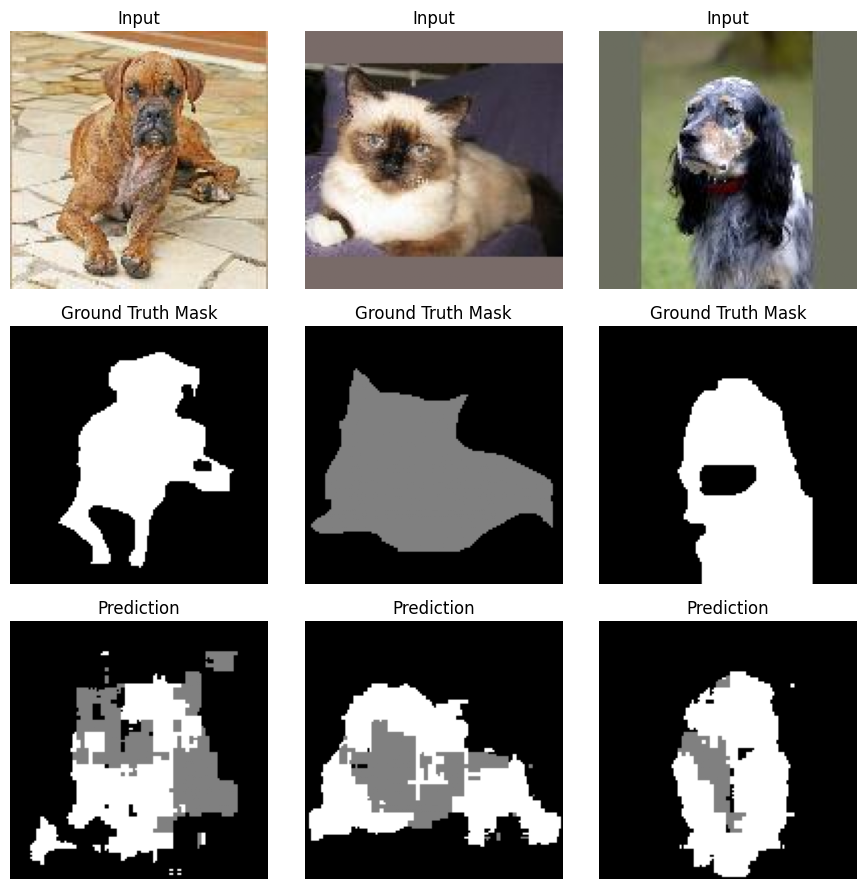

Merged PDF saved as AE_prediction_examples.pdf


In [ ]:
if __name__ == "__main__":
    import os
    import random
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    from torchvision import transforms
    from torch.utils.data import ConcatDataset, DataLoader, random_split
    from matplotlib.colors import ListedColormap
    import fitz  # PyMuPDF
    from PIL import Image
    from pathlib import Path

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # Suppose this is your entire labeled dataset
    full_dataset = SegmentationDataset(
        root_dir=str(local_dataset_path / "TrainVal"),  # or wherever the data is
        transform_img=transforms.Compose([transforms.ToTensor()]),
        transform_label=None  # or transforms if needed
    )

    # ----------------------------------------------------
    # 1) Split the Full Dataset into Two Big Subsets:
    #    One subset used for the autoencoder,
    #    another subset used for segmentation.
    #    For example, 80% for autoencoder, 20% for segmentation.
    # ----------------------------------------------------
    dataset_size = len(full_dataset)
    ae_size = int(0.80 * dataset_size)  # 80% for AE
    seg_size = dataset_size - ae_size   # 20% for segmentation

    ae_full_dataset, seg_full_dataset = random_split(
        full_dataset,
        [ae_size, seg_size],
        generator=torch.Generator().manual_seed(42)  # for reproducibility
    )

    # ----------------------------------------------------
    # 2) Within the AE subset, split into (train, val)
    # ----------------------------------------------------
    val_ratio_ae = 0.10  # 10% of AE subset for val
    ae_train_size = int((1 - val_ratio_ae) * ae_size)
    ae_val_size = ae_size - ae_train_size

    ae_train_dataset, ae_val_dataset = random_split(
        ae_full_dataset,
        [ae_train_size, ae_val_size],
        generator=torch.Generator().manual_seed(42)
    )

    print(f"Autoencoder: train={len(ae_train_dataset)}, val={len(ae_val_dataset)}")

    # ----------------------------------------------------
    # 3) Within the Segmentation subset, split into (train, val)
    # ----------------------------------------------------
    val_ratio_seg = 0.10  # 10% of seg subset for val
    seg_train_size = int((1 - val_ratio_seg) * seg_size)
    seg_val_size = seg_size - seg_train_size

    seg_train_dataset, seg_val_dataset = random_split(
        seg_full_dataset,
        [seg_train_size, seg_val_size],
        generator=torch.Generator().manual_seed(1234)
    )

    print(f"Segmentation: train={len(seg_train_dataset)}, val={len(seg_val_dataset)}")

    # ----------------------------------------------------
    # 4) Train the Autoencoder
    # ----------------------------------------------------
    autoencoder = SimpleAutoencoder(in_channels=3, latent_dim=512)
    autoencoder = train_autoencoder(
        model=autoencoder,
        train_dataset=ae_train_dataset,
        val_dataset=ae_val_dataset,    # separate AE validation set
        epochs=100,
        batch_size=32,
        lr=5e-4,
        save_every=10,
        early_stopping_patience=10,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    )

    # (Optionally visualize reconstructions)
    visualize_reconstruction(autoencoder, ae_val_dataset, device=device, num_samples=3)

    # Free unused GPU memory before starting segmentation training
    torch.cuda.empty_cache()

    # Load the final autoencoder weights to ensure we use the best encoder for segmentation training
    autoencoder_path = os.path.join("/content/drive/MyDrive", "checkpoints", "autoencoder", "autoencoder_final.pth")
    autoencoder.load_state_dict(torch.load(autoencoder_path))
    print("Loaded final autoencoder weights from", autoencoder_path)

    # ----------------------------------------------------
    # 5) Freeze encoder, build segmentation model
    # ----------------------------------------------------
    segmenter = Segmenter(autoencoder, num_classes=3)

    # Load segmentation model checkpoint if available to continue training
    seg_checkpoint_path = '/content/drive/MyDrive/checkpoints/segmenter/segmenter_final.pth'
    if os.path.exists(seg_checkpoint_path):
        checkpoint = torch.load(seg_checkpoint_path, map_location=device)
        if isinstance(checkpoint, dict) and "state_dict" in checkpoint:
            segmenter.load_state_dict(checkpoint["state_dict"])
        else:
            segmenter.load_state_dict(checkpoint)
        print("Loaded segmentation model checkpoint from", seg_checkpoint_path)
    else:
        print("Checkpoint not found at:", seg_checkpoint_path)

    # Optionally Expand the dataset
    seg_all_train_dataset = ConcatDataset([seg_train_dataset, ae_train_dataset])
    seg_all_val_dataset = ConcatDataset([seg_val_dataset, ae_val_dataset])  # NEW

    # ----------------------------------------------------
    # 6) Train the segmentation model using its *own* subsets
    # ----------------------------------------------------
    segmenter = train_segmentation_decoder(
        model=segmenter,
        train_dataset=seg_all_train_dataset,
        val_dataset=seg_all_val_dataset,   # separate segmentation validation set
        epochs=200,
        batch_size=32,  # 16, 32
        lr=5e-3,
        save_every=40,
        early_stopping_patience=40,  # 40
        num_classes=3,
        device=device
    )

    # ----------------------------------------------------
    # 7) Evaluate on Test Data
    # ----------------------------------------------------
    test_dataset = SegmentationDataset(
        root_dir=str(local_dataset_path / "Test"),
        transform_img=transforms.Compose([transforms.ToTensor()]),
        transform_label=None  # or transforms if you have test labels
    )
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)
    segmenter.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for imgs, masks in test_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            logits = segmenter(imgs)
            loss = criterion(logits, masks)
            total_loss += loss.item() * imgs.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_targets.append(masks.cpu())

    test_loss = total_loss / len(test_dataset)
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute IoU per class
    ious = compute_iou(all_preds, all_targets, num_classes=3)
    mean_iou = np.nanmean(ious)

    # Compute Dice coefficient per class
    def compute_dice(preds, targets, num_classes=3):
      dices = []
      for cls in range(num_classes):
          pred_inds = (preds == cls)
          target_inds = (targets == cls)
          intersection = (pred_inds & target_inds).sum().item()
          dice = (2.0 * intersection) / (pred_inds.sum().item() + target_inds.sum().item() + 1e-8)
          dices.append(dice)
      return dices

    dices = compute_dice(all_preds, all_targets, num_classes=3)
    mean_dice = np.mean(dices)

    # Compute Pixel Accuracy
    correct_pixels = (all_preds == all_targets).sum().item()
    total_pixels = all_targets.numel()
    pixel_accuracy = correct_pixels / total_pixels

    # Print the evaluation metrics
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test mIoU: {mean_iou:.4f}")
    print(f"Background IoU: {ious[0]:.4f}, Cat IoU: {ious[1]:.4f}, Dog IoU: {ious[2]:.4f}")
    print(f"Mean Dice: {mean_dice:.4f}")
    print(f"Pixel Accuracy: {pixel_accuracy:.4f}")

    # Show a few test predictions
    visualize_segmentation_predictions(segmenter, test_dataset, device=device, num_samples=3, num_classes=3)

    # -----------------------------
    # Generate PDF Examples from Selected Test Samples
    # -----------------------------
    # Choose a few random indices and add required ones.
    num_plots = 3
    random_indices = random.sample(range(len(test_dataset)), num_plots)
    required_indices = [353, 2619, 1619]  # Change these to your preferred indices
    indices = list(set(random_indices + required_indices))

    # Define colormaps for visualization (adjust as needed).
    cmap_gt = ListedColormap(['black', 'orange', 'cyan', 'white'])
    cmap_pred = ListedColormap(['black', 'orange', 'cyan'])

    def denormalize(image_tensor):
        mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(3, 1, 1)
        std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(3, 1, 1)
        image_tensor = image_tensor * std + mean
        image_tensor = torch.clamp(image_tensor, 0, 1)
        return image_tensor

    # Loop through selected indices to create and save individual PDFs.
    for idx in indices:
        # Get the sample; adjust based on what your dataset returns.
        sample = test_dataset[idx]
        if len(sample) == 3:
            image, gt_mask, token_ids = sample
        else:
            image, gt_mask = sample
            token_ids = None

        # Re-load the original mask from file using dataset attributes.
        mask_filename = test_dataset.image_files[idx].name
        mask_path = os.path.join(test_dataset.label_dir, Path(mask_filename).stem + ".png")
        mask_img = Image.open(mask_path).convert("RGB")
        mask_np = np.array(mask_img, dtype=np.uint8)

        # Build a ground truth visualization mask.
        gt_vis = np.zeros(mask_np.shape[:2], dtype=np.int64)
        background_mask = (mask_np[..., 0] == 0) & (mask_np[..., 1] == 0) & (mask_np[..., 2] == 0)
        cat_mask = (mask_np[..., 0] == 255) & (mask_np[..., 1] == 165) & (mask_np[..., 2] == 0)
        dog_mask = (mask_np[..., 0] == 0) & (mask_np[..., 1] == 255) & (mask_np[..., 2] == 255)
        gt_vis[background_mask] = 0
        gt_vis[cat_mask] = 1
        gt_vis[dog_mask] = 2
        boundary_mask = ~(background_mask | cat_mask | dog_mask)
        gt_vis[boundary_mask] = 3

        # Get the model prediction.
        image_tensor = image.unsqueeze(0).to(device)
        # If your model requires token_ids, adjust the call accordingly.
        with torch.no_grad():
            output = segmenter(image_tensor)
        pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

        # Denormalize image for display.
        img_np = denormalize(image).cpu().permute(1, 2, 0).numpy()

        # Plot input image, ground truth, and prediction.
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img_np)
        plt.title("Input Image")
        plt.subplot(1, 3, 2)
        plt.imshow(gt_vis, cmap=cmap_gt, vmin=-0.5, vmax=3.5)
        plt.title("Ground Truth")
        plt.subplot(1, 3, 3)
        plt.imshow(pred, cmap=cmap_pred, vmin=-0.5, vmax=2.5)
        plt.title("Prediction")
        pdf_filename = f"AE_sample_{idx}.pdf"
        plt.savefig(pdf_filename)
        plt.close()  # Close the figure to free memory

    # -----------------------------
    # Merge the Generated PDFs into a Single-Page PDF
    # -----------------------------
    def merge_pdfs_to_single_page(pdf_list, output_path, dpi=150):
        """
        Render the first page of each PDF as an image, stitch them vertically,
        and save as a single-page PDF.

        Arguments:
          pdf_list: list of PDF file paths.
          output_path: path to save the merged PDF.
          dpi: resolution for rendering.
        """
        images = []
        for pdf in pdf_list:
            doc = fitz.open(pdf)
            page = doc.load_page(0)
            zoom = dpi / 72.0
            mat = fitz.Matrix(zoom, zoom)
            pix = page.get_pixmap(matrix=mat)
            img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
            images.append(img)
            doc.close()

        widths, heights = zip(*(im.size for im in images))
        max_width = max(widths)
        total_height = sum(heights)
        merged_img = Image.new('RGB', (max_width, total_height), color=(255, 255, 255))
        y_offset = 0
        for im in images:
            merged_img.paste(im, (0, y_offset))
            y_offset += im.height

        merged_img.save(output_path, "PDF", resolution=dpi)
        print(f"Merged PDF saved as {output_path}")

    pdf_files = [f"AE_sample_{idx}.pdf" for idx in indices]
    output_pdf = 'AE_prediction_examples.pdf'
    merge_pdfs_to_single_page(pdf_files, output_pdf, dpi=150)

## PDFs

In [28]:
pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 58.0 MB/s eta 0:00:00


In [34]:
#!/usr/bin/env python
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import ConcatDataset, DataLoader, random_split
from matplotlib.colors import ListedColormap
from PIL import Image
from pathlib import Path
import fitz

# --- Helper Functions & Colormaps ---
# Define colormaps for predictions and ground truth visualization.
cmap_pred = ListedColormap(['black', 'orange', 'cyan'])
cmap_gt   = ListedColormap(['black', 'orange', 'cyan', 'white'])

local_dataset_path = Path("/content/processed_3")


def denormalize(image_tensor):
    """
    Denormalize an image tensor using the provided mean and std.
    """
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(3, 1, 1)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(3, 1, 1)
    image_tensor = image_tensor * std + mean
    return torch.clamp(image_tensor, 0, 1)

def visualize_segmentation_predictions(model, test_dataset, device, indices, output_prefix):
    """
    For each given index:
      - Reload the original ground truth mask from disk.
      - Build a visualization mask with the following mapping:
             background -> 0, cat -> 1, dog -> 2, and boundaries -> 3.
      - Run the model to obtain prediction (with optional token IDs if present).
      - Denormalize and plot the input image, ground truth, and prediction.
      - Save the visualization as an individual PDF.

    Parameters:
      model         : The segmentation model.
      test_dataset  : Test dataset (should contain image and label info).
      device        : Device (CPU or CUDA) to perform computation.
      indices       : List of indices (ints) to visualize.
      output_prefix : Filename prefix for each PDF.
    """
    for idx in indices:
        # --- Get sample from dataset ---
        # Assumes sample is (image, gt_mask, token_ids) or (image, gt_mask)
        sample = test_dataset[idx]
        if len(sample) == 3:
            image, _, token_ids = sample
        else:
            image, _ = sample
            token_ids = None

        # --- Reload the original ground truth mask ---
        # Expecting test_dataset to have either 'image_files' (with .name) or 'image_paths'
        if hasattr(test_dataset, 'image_files'):
            mask_filename = test_dataset.image_files[idx].name
        elif hasattr(test_dataset, 'image_paths'):
            mask_filename = test_dataset.image_paths[idx]
        else:
            raise AttributeError("Test dataset must have attribute 'image_files' or 'image_paths'.")

        # Use dataset attribute to determine where the masks are stored.
        mask_dir = test_dataset.label_dir if hasattr(test_dataset, 'label_dir') else test_dataset.mask_dir
        mask_path = os.path.join(mask_dir, Path(mask_filename).stem + ".png")
        mask_img = Image.open(mask_path).convert("RGB")
        mask_np = np.array(mask_img, dtype=np.uint8)

        # --- Build ground truth visualization mask ---
        # Mapping: background -> 0, cat -> 1, dog -> 2, and boundaries -> 3.
        gt_vis = np.zeros(mask_np.shape[:2], dtype=np.int64)
        background_mask = (mask_np[..., 0] == 0) & (mask_np[..., 1] == 0) & (mask_np[..., 2] == 0)
        cat_mask = (mask_np[..., 0] == 255) & (mask_np[..., 1] == 165) & (mask_np[..., 2] == 0)
        dog_mask = (mask_np[..., 0] == 0) & (mask_np[..., 1] == 255) & (mask_np[..., 2] == 255)
        gt_vis[background_mask] = 0
        gt_vis[cat_mask] = 1
        gt_vis[dog_mask] = 2
        boundary_mask = ~(background_mask | cat_mask | dog_mask)
        gt_vis[boundary_mask] = 3

        # --- Get model prediction ---
        image_tensor = image.unsqueeze(0).to(device)
        if token_ids is not None:
            token_ids_tensor = token_ids.unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(image_tensor, token_ids_tensor)
        else:
            with torch.no_grad():
                output = model(image_tensor)
        pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

        # --- Denormalize the input image ---
        # img_np = denormalize(image).cpu().permute(1, 2, 0).numpy()
        img_np = image.cpu().permute(1, 2, 0).numpy()

        # --- Plot input, ground truth, and prediction ---
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img_np)
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(gt_vis, cmap=cmap_gt, vmin=-0.5, vmax=3.5)
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(pred, cmap=cmap_pred, vmin=-0.5, vmax=2.5)
        plt.title("Prediction")
        plt.axis('off')

        pdf_filename = f"{output_prefix}_{idx}.pdf"
        plt.savefig(pdf_filename, bbox_inches='tight')
        plt.close()
        print(f"Saved visualization to {pdf_filename}")

def merge_pdfs_to_single_page(pdf_list, output_path, dpi=150):
    """
    Merge individual single-page PDFs (each containing a visualization)
    into one vertically stitched PDF page.

    Parameters:
      pdf_list   : List of file paths to PDFs.
      output_path: Output filename for the merged PDF.
      dpi        : Resolution for rendering the pages.
    """
    images = []
    for pdf in pdf_list:
        doc = fitz.open(pdf)
        page = doc.load_page(0)
        zoom = dpi / 72.0  # Convert from default dpi to desired dpi
        mat = fitz.Matrix(zoom, zoom)
        pix = page.get_pixmap(matrix=mat)
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        images.append(img)
        doc.close()

    widths, heights = zip(*(im.size for im in images))
    max_width = max(widths)
    total_height = sum(heights)
    merged_img = Image.new('RGB', (max_width, total_height), color=(255, 255, 255))
    y_offset = 0
    for im in images:
        merged_img.paste(im, (0, y_offset))
        y_offset += im.height

    merged_img.save(output_path, "PDF", resolution=dpi)
    print(f"Merged PDF saved as {output_path}")

# --- Main Script ---
if __name__ == "__main__":
    # NOTE: The following assumes that the following are defined:
    #    SegmentationDataset, SimpleAutoencoder, Segmenter,
    #    train_autoencoder, visualize_reconstruction, train_segmentation_decoder,
    #    compute_iou, and local_dataset_path.
    #
    # Adjust paths and function imports as needed for your project.

    # Set up device.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # ---- Dataset Setup ----
    full_dataset = SegmentationDataset(
        root_dir=str(local_dataset_path / "TrainVal"),
        transform_img=transforms.Compose([transforms.ToTensor()]),
        transform_label=None  # Or use label transforms if needed
    )

    # Split full_dataset into autoencoder and segmentation subsets.
    dataset_size = len(full_dataset)
    ae_size = int(0.80 * dataset_size)
    seg_size = dataset_size - ae_size
    ae_full_dataset, seg_full_dataset = random_split(
        full_dataset, [ae_size, seg_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Split AE subset into train and validation.
    val_ratio_ae = 0.10
    ae_train_size = int((1 - val_ratio_ae) * ae_size)
    ae_val_size = ae_size - ae_train_size
    ae_train_dataset, ae_val_dataset = random_split(
        ae_full_dataset, [ae_train_size, ae_val_size],
        generator=torch.Generator().manual_seed(42)
    )
    print(f"Autoencoder: train={len(ae_train_dataset)}, val={len(ae_val_dataset)}")

    # Split segmentation subset into train and validation.
    val_ratio_seg = 0.10
    seg_train_size = int((1 - val_ratio_seg) * seg_size)
    seg_val_size = seg_size - seg_train_size
    seg_train_dataset, seg_val_dataset = random_split(
        seg_full_dataset, [seg_train_size, seg_val_size],
        generator=torch.Generator().manual_seed(1234)
    )
    print(f"Segmentation: train={len(seg_train_dataset)}, val={len(seg_val_dataset)}")

    # # ---- Train the Autoencoder (or assume training is complete) ----
    autoencoder = SimpleAutoencoder(in_channels=3, latent_dim=512)
    # autoencoder = train_autoencoder(
    #     model=autoencoder,
    #     train_dataset=ae_train_dataset,
    #     val_dataset=ae_val_dataset,
    #     epochs=100,
    #     batch_size=32,
    #     lr=5e-4,
    #     save_every=10,
    #     early_stopping_patience=10,
    #     device=device
    # )
    # # Optionally, visualize reconstructions.
    # visualize_reconstruction(autoencoder, ae_val_dataset, device=device, num_samples=3)

    # Clear GPU memory before segmentation training.
    torch.cuda.empty_cache()

    # ---- Load Saved Autoencoder Weights ----
    autoencoder_path = os.path.join("/content/drive/MyDrive", "checkpoints", "autoencoder", "autoencoder_final.pth")
    autoencoder.load_state_dict(torch.load(autoencoder_path))
    print("Loaded final autoencoder weights from", autoencoder_path)

    # ---- Build & Load the Segmentation Model ----
    segmenter = Segmenter(autoencoder, num_classes=3)
    seg_checkpoint_path = '/content/drive/MyDrive/checkpoints/segmenter/segmenter_final.pth'
    if os.path.exists(seg_checkpoint_path):
        checkpoint = torch.load(seg_checkpoint_path, map_location=device)
        if isinstance(checkpoint, dict) and "state_dict" in checkpoint:
            segmenter.load_state_dict(checkpoint["state_dict"])
        else:
            segmenter.load_state_dict(checkpoint)
        print("Loaded segmentation model checkpoint from", seg_checkpoint_path)
    else:
        print("Checkpoint not found at:", seg_checkpoint_path)

    segmenter = segmenter.to(device)
    # Optionally, expand segmentation training dataset.
    seg_all_train_dataset = ConcatDataset([seg_train_dataset, ae_train_dataset])
    seg_all_val_dataset = ConcatDataset([seg_val_dataset, ae_val_dataset])

    # # ---- Train the Segmentation Model (if desired) ----
    # segmenter = train_segmentation_decoder(
    #     model=segmenter,
    #     train_dataset=seg_all_train_dataset,
    #     val_dataset=seg_all_val_dataset,
    #     epochs=200,
    #     batch_size=32,
    #     lr=5e-3,
    #     save_every=40,
    #     early_stopping_patience=40,
    #     num_classes=3,
    #     device=device
    # )

    # ---- Evaluate on Test Data ----
    test_dataset = SegmentationDataset(
        root_dir=str(local_dataset_path / "Test"),
        transform_img=transforms.Compose([transforms.ToTensor()]),
        transform_label=None
    )
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)
    segmenter.eval()
    criterion = torch.nn.CrossEntropyLoss()
    total_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for imgs, masks in test_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            logits = segmenter(imgs)
            loss = criterion(logits, masks)
            total_loss += loss.item() * imgs.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_targets.append(masks.cpu())

    test_loss = total_loss / len(test_dataset)
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute IoU per class.
    ious = compute_iou(all_preds, all_targets, num_classes=3)
    mean_iou = np.nanmean(ious)

    # Compute Dice coefficients.
    def compute_dice(preds, targets, num_classes=3):
        dices = []
        for cls in range(num_classes):
            pred_inds = (preds == cls)
            target_inds = (targets == cls)
            intersection = (pred_inds & target_inds).sum().item()
            dice = (2.0 * intersection) / (pred_inds.sum().item() + target_inds.sum().item() + 1e-8)
            dices.append(dice)
        return dices
    dices = compute_dice(all_preds, all_targets, num_classes=3)
    mean_dice = np.mean(dices)

    # Compute Pixel Accuracy.
    correct_pixels = (all_preds == all_targets).sum().item()
    total_pixels = all_targets.numel()
    pixel_accuracy = correct_pixels / total_pixels

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test mIoU: {mean_iou:.4f}")
    print(f"Background IoU: {ious[0]:.4f}, Cat IoU: {ious[1]:.4f}, Dog IoU: {ious[2]:.4f}")
    print(f"Mean Dice: {mean_dice:.4f}")
    print(f"Pixel Accuracy: {pixel_accuracy:.4f}")

    # ---- Generate PDF Visualizations from Selected Test Samples ----
    # Choose a few random indices plus required ones.
    num_plots = 3
    random_indices = random.sample(range(len(test_dataset)), num_plots)
    required_indices = [353, 2619, 1619]  # Modify as preferred.
    indices = list(set(required_indices))
    output_prefix = "AE_sample"

    # Generate individual PDFs for each selected sample.
    visualize_segmentation_predictions(segmenter, test_dataset, device, indices, output_prefix)

    # Merge the individual PDFs into a single-page PDF.
    pdf_files = [f"{output_prefix}_{idx}.pdf" for idx in indices]
    output_pdf = "AE_prediction_examples.pdf"
    merge_pdfs_to_single_page(pdf_files, output_pdf, dpi=150)

Using device: cuda
Autoencoder: train=16072, val=1786
Segmentation: train=4018, val=447
Loaded final autoencoder weights from /content/drive/MyDrive/checkpoints/autoencoder/autoencoder_final.pth
Loaded segmentation model checkpoint from /content/drive/MyDrive/checkpoints/segmenter/segmenter_final.pth
Test Loss: 0.5294
Test mIoU: 0.4619
Background IoU: 0.8380, Cat IoU: 0.1888, Dog IoU: 0.3588
Mean Dice: 0.5859
Pixel Accuracy: 0.8138
Saved visualization to AE_sample_353.pdf
Saved visualization to AE_sample_1619.pdf
Saved visualization to AE_sample_2619.pdf
Merged PDF saved as AE_prediction_examples.pdf
